In [1]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(ggsignif)))
# import ggplot theme
source("../../utils/figure_themes.r")

In [2]:
# path to the anova data
mean_aggregated_anova_genotype_df_path <- file.path("..","..","data","6.analysis_results","mean_aggregated_anova_results.parquet")
mean_aggregated_data_path <- file.path("..","..","data","5.converted_data","mean_aggregated_data.parquet")
fig_path <- file.path("..","figures","mean_aggregated")
# create the figure directory if it does not exist
if (!dir.exists(fig_path)){
  dir.create(fig_path, recursive = TRUE)
}

# read the data
mean_aggregated_data_df <- arrow::read_parquet(mean_aggregated_data_path)
head(mean_aggregated_data_df)

# read the anova data
mean_aggregated_anova_df <- arrow::read_parquet(mean_aggregated_anova_genotype_df_path)


Metadata_genotype,Metadata_replicate,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,AreaShape_CentralMoment_1_2,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high,1,0.5964828,0.5964828,0.27087628,-0.04923743,0.39086810,2.1009152,-0.4639369,-0.04298225,⋯,-0.10410518,-0.11903633,-0.54585578,-0.52502679,-0.54330471,-0.54458881,-0.5575633,-0.5621014,-0.5589764,-0.5608718
high,10,1.2389540,1.2389540,0.65981303,1.72236419,-0.87429732,0.1791951,-1.6447597,0.82527013,⋯,0.64697719,0.63535604,0.63068191,0.64209101,0.59375379,0.63527378,0.5578628,0.5484734,0.5609847,0.5477695
high,11,2.1312071,2.1312071,0.63086554,1.42646941,0.29159110,1.8012069,-0.2706624,-0.16430652,⋯,0.68677092,0.67823043,0.55238246,0.57082297,0.52626599,0.54847464,0.4988255,0.4862685,0.5000832,0.4902130
high,12,1.2012381,1.2012381,0.02494302,1.27911918,-0.46408552,-1.6528531,-0.9823093,0.10767961,⋯,0.30950471,0.30893327,-0.05477867,-0.05987619,-0.09839988,-0.06793023,-0.1037820,-0.1093674,-0.1010855,-0.1067718
high,13,1.1948884,1.1948884,-0.55436803,-0.03446555,0.05088249,-1.3449799,-0.4836727,-0.79443383,⋯,0.05670642,0.04774139,-0.32517061,-0.29567384,-0.32103861,-0.32243559,-0.3484087,-0.3562547,-0.3502858,-0.3521677
high,14,2.2767921,2.2767921,-2.38853596,1.69171903,0.12573685,-0.7138870,-1.5904088,0.11087396,⋯,1.02706597,1.02583400,1.25542512,1.27093366,1.20964214,1.24875506,1.1673985,1.1480302,1.1718716,1.1541288


## Genotype, side and identity level data

### ANOVA means

In [3]:

mean_aggregated_anova_df$log10_anova_p_value <- -log10(mean_aggregated_anova_df$anova_p_value)
# order the results by log10 anova p-value
mean_aggregated_anova_df <- mean_aggregated_anova_df %>% arrange(log10_anova_p_value)
# split the feature into 3 groups at "_"
mean_aggregated_anova_df$feature_type <- sapply(strsplit(mean_aggregated_anova_df$feature, "_"), function(x) x[1])
mean_aggregated_anova_df$feature_name <- sapply(strsplit(mean_aggregated_anova_df$feature, "_"), function(x) x[2])
head(mean_aggregated_anova_df)


group1,group2,meandiff,p-adj,lower,upper,reject,feature,anova_p_value,log10_anova_p_value,feature_type,feature_name
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
high,unsel,0.0435,0.9795,-0.5038,0.5909,FALSE,RadialDistribution_ZernikePhase_OP_7_5,0.9548407,0.02006906,RadialDistribution,ZernikePhase
high,wt,0.0674,0.9517,-0.4799,0.6147,FALSE,RadialDistribution_ZernikePhase_OP_7_5,0.9548407,0.02006906,RadialDistribution,ZernikePhase
unsel,wt,0.0239,0.9938,-0.5235,0.5712,FALSE,RadialDistribution_ZernikePhase_OP_7_5,0.9548407,0.02006906,RadialDistribution,ZernikePhase
high,unsel,-0.0133,0.9991,-0.8050,0.7785,FALSE,AreaShape_CentralMoment_1_0,0.9440693,0.02499612,AreaShape,CentralMoment
high,wt,0.0882,0.9602,-0.7035,0.8800,FALSE,AreaShape_CentralMoment_1_0,0.9440693,0.02499612,AreaShape,CentralMoment
unsel,wt,0.1015,0.9477,-0.6902,0.8932,FALSE,AreaShape_CentralMoment_1_0,0.9440693,0.02499612,AreaShape,CentralMoment


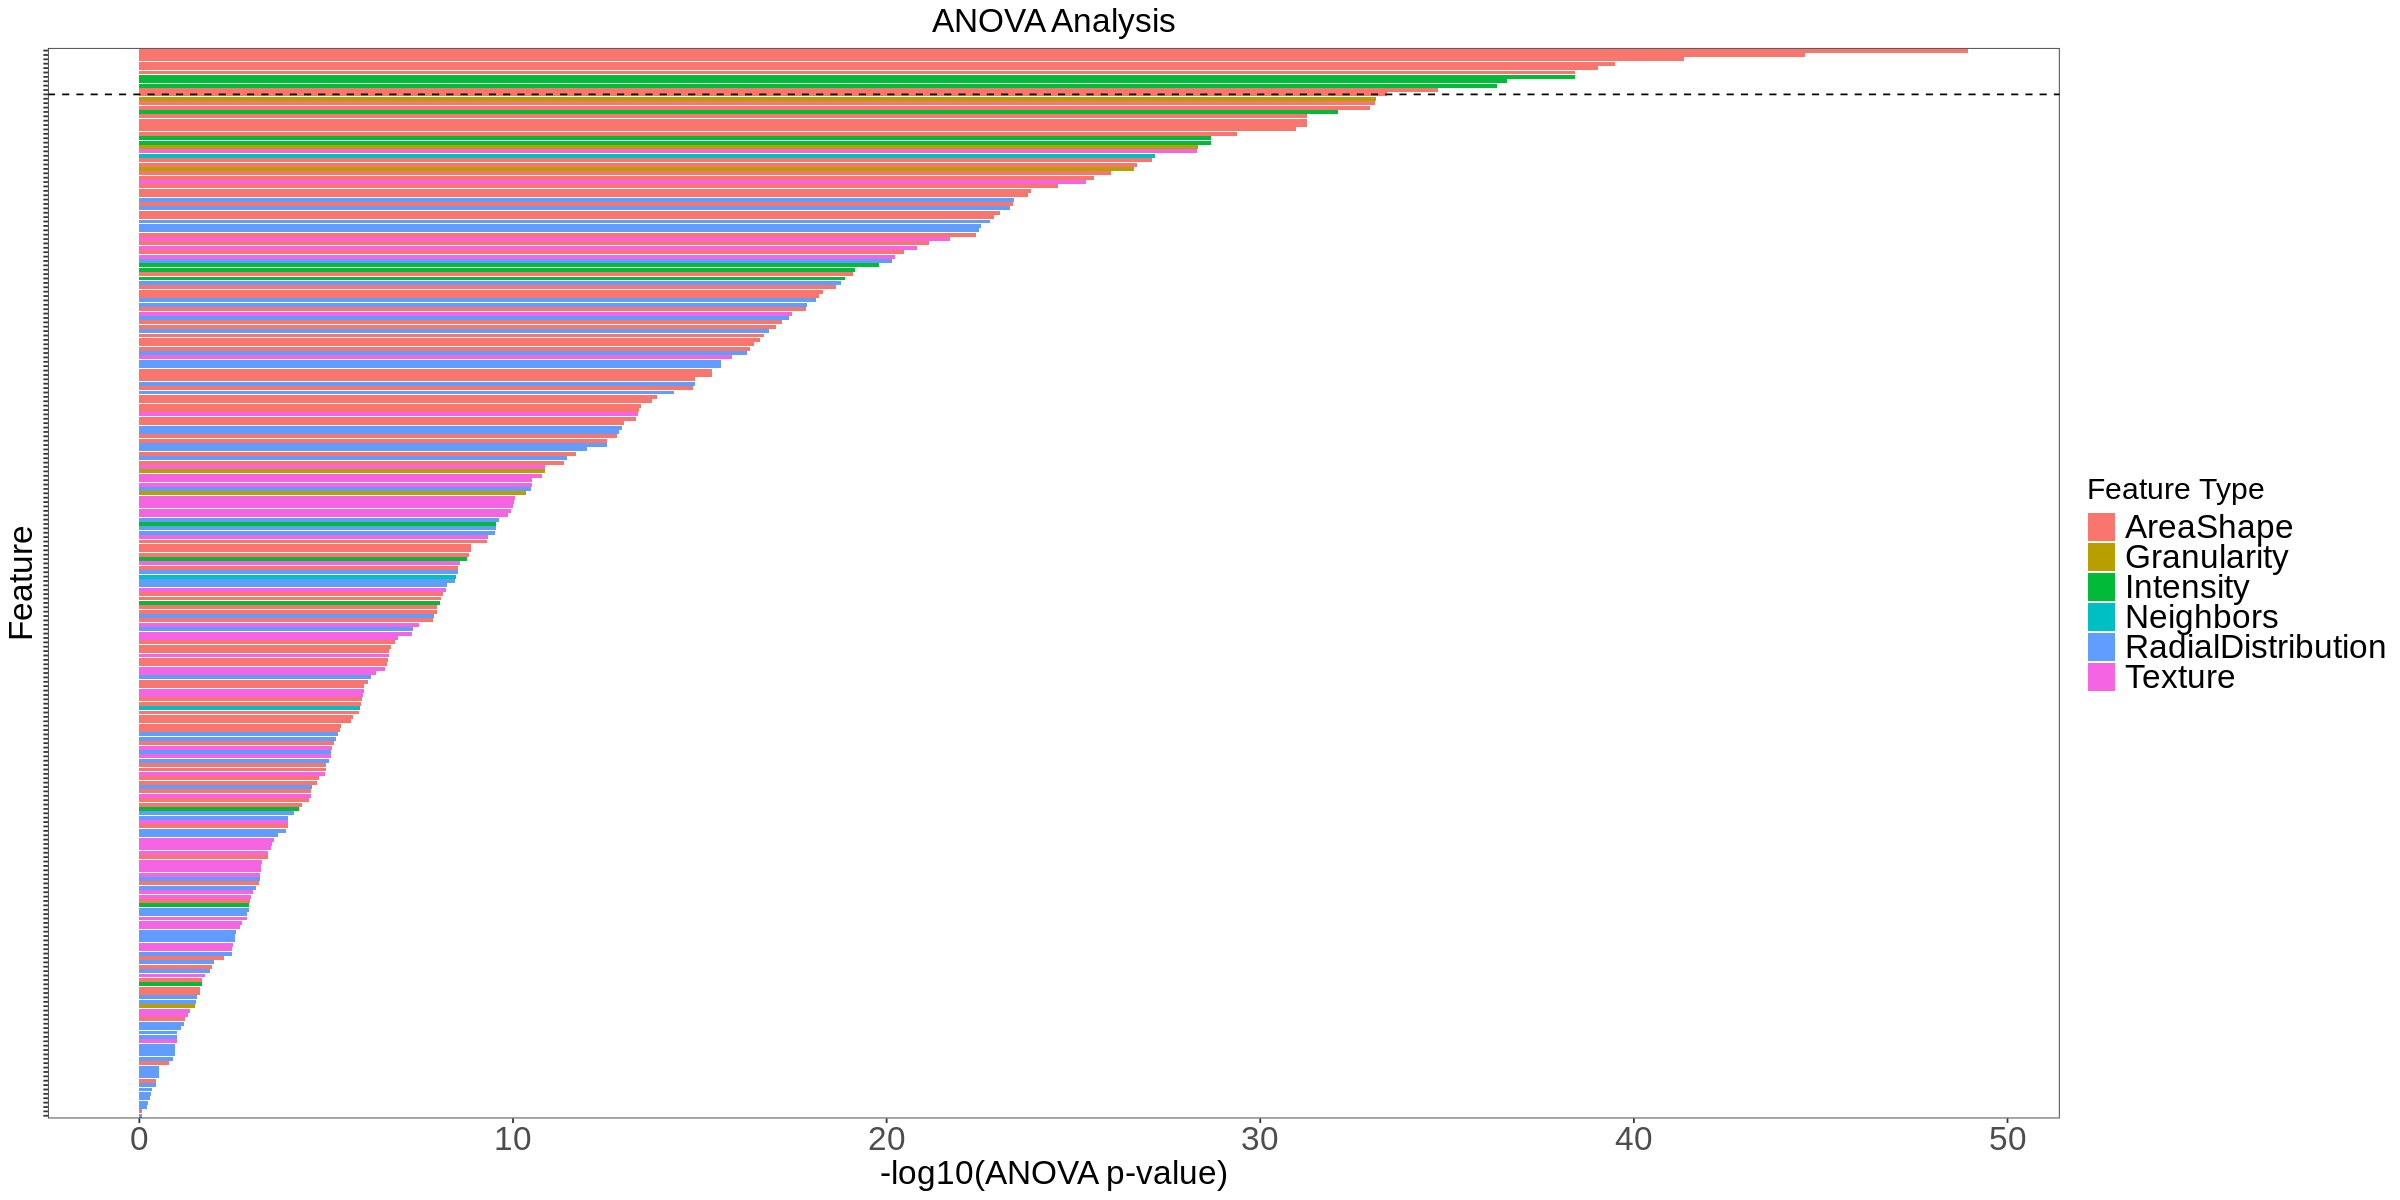

In [4]:
width <- 20
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
anova_plot <- (
    # order the results by log10 anova p-value
    ggplot(mean_aggregated_anova_df, aes(y = reorder(feature, log10_anova_p_value), x = log10_anova_p_value, fill = feature_type))
    + geom_bar(stat = "identity")
    # drop y axis labels
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + labs(title = "ANOVA Analysis", y = "Feature", x = "-log10(ANOVA p-value)", fill = "Feature Type")
   
    + figure_theme


    + theme(axis.text.y = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    + theme(axis.text.y = element_blank())
    + geom_hline(yintercept = length(unique(mean_aggregated_anova_df$feature))-10, linetype = "dashed", color = "black")
     
)
anova_plot
# save the plot
ggsave(file = "mean_aggregated_anova_plot.png", plot = anova_plot, path = file.path(fig_path), width = width, height = height, dpi = 600)

## Test for equality of variance 

In [5]:
# load levene data in 
mean_aggregated_levene_df_path <- file.path("..","..","data","6.analysis_results","mean_aggregated_levene_test_results.csv")
mean_aggregated_levene_df <- read.csv(mean_aggregated_levene_df_path)
# make a new column for ***
mean_aggregated_levene_df$significance <- ifelse(
    mean_aggregated_levene_df$levene_p_value < 0.001, "***", 
    ifelse(mean_aggregated_levene_df$levene_p_value < 0.01, "**", 
    ifelse(mean_aggregated_levene_df$levene_p_value < 0.05, "*", 
    "ns")
    )
)
head(mean_aggregated_levene_df)

,X,feature,levene_statistic,levene_p_value,group,significance
,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,128,RadialDistribution_MeanFrac_OP_3of4,5.743202e-06,0.9981062,high_vs_unsel,ns
2,909,RadialDistribution_ZernikePhase_OP_6_6,1.928452e-03,0.9980735,all,ns
3,0,AreaShape_Area,5.003355e-05,0.9944103,high_vs_unsel,ns
4,1,AreaShape_CentralMoment_0_0,5.003355e-05,0.9944103,high_vs_unsel,ns
5,56,AreaShape_SpatialMoment_0_0,5.003355e-05,0.9944103,high_vs_unsel,ns
6,678,RadialDistribution_ZernikePhase_OP_9_7,2.582189e-04,0.9873019,unsel_vs_wt,ns


### Variances

In [6]:
width <- 4
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
# make a new column for the group1 and group2
mean_aggregated_anova_df$comparison <- paste(mean_aggregated_anova_df$group1, mean_aggregated_anova_df$group2, sep = " - ")

# order the results by anova p-value
mean_aggregated_anova_df <- mean_aggregated_anova_df %>% arrange(anova_p_value)
features <- unique(mean_aggregated_anova_df$feature)[1:20]
features
top_20_mean_aggregated_anova_df <- mean_aggregated_anova_df %>% filter(feature %in% features)
top_20_mean_aggregated_anova_df$log10_tukey_p_value <- -log10(top_20_mean_aggregated_anova_df$`p-adj`)
# make the genotype a factor
# replace the genotype values
mean_aggregated_data_df$Metadata_genotype <- gsub("wt", "Wild Type", mean_aggregated_data_df$Metadata_genotype)
mean_aggregated_data_df$Metadata_genotype <- gsub("unsel", "Mid-Severity", mean_aggregated_data_df$Metadata_genotype)
mean_aggregated_data_df$Metadata_genotype <- gsub("high", "High-Severity", mean_aggregated_data_df$Metadata_genotype)
mean_aggregated_data_df$Metadata_genotype <- factor(
    mean_aggregated_data_df$Metadata_genotype, 
    levels = c("Wild Type", "Mid-Severity", "High-Severity")
)
head(mean_aggregated_data_df)

[1] "AreaShape_Zernike_2_0"               "AreaShape_Zernike_0_0"              
 [3] "AreaShape_HuMoment_0"                "AreaShape_MedianRadius"             
 [5] "AreaShape_MaximumRadius"             "AreaShape_MeanRadius"               
 [7] "Intensity_MeanIntensityEdge_OP"      "Intensity_StdIntensityEdge_OP"      
 [9] "Intensity_MaxIntensityEdge_OP"       "AreaShape_NormalizedMoment_2_0"     
[11] "AreaShape_MinFeretDiameter"          "Granularity_3_OP"                   
[13] "AreaShape_EquivalentDiameter"        "AreaShape_MinorAxisLength"          
[15] "Intensity_LowerQuartileIntensity_OP" "AreaShape_Area"                     
[17] "AreaShape_CentralMoment_0_0"         "AreaShape_SpatialMoment_0_0"        
[19] "AreaShape_HuMoment_1"                "AreaShape_SpatialMoment_1_0"

Metadata_genotype,Metadata_replicate,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,AreaShape_CentralMoment_1_2,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High-Severity,1,0.5964828,0.5964828,0.27087628,-0.04923743,0.39086810,2.1009152,-0.4639369,-0.04298225,⋯,-0.10410518,-0.11903633,-0.54585578,-0.52502679,-0.54330471,-0.54458881,-0.5575633,-0.5621014,-0.5589764,-0.5608718
High-Severity,10,1.2389540,1.2389540,0.65981303,1.72236419,-0.87429732,0.1791951,-1.6447597,0.82527013,⋯,0.64697719,0.63535604,0.63068191,0.64209101,0.59375379,0.63527378,0.5578628,0.5484734,0.5609847,0.5477695
High-Severity,11,2.1312071,2.1312071,0.63086554,1.42646941,0.29159110,1.8012069,-0.2706624,-0.16430652,⋯,0.68677092,0.67823043,0.55238246,0.57082297,0.52626599,0.54847464,0.4988255,0.4862685,0.5000832,0.4902130
High-Severity,12,1.2012381,1.2012381,0.02494302,1.27911918,-0.46408552,-1.6528531,-0.9823093,0.10767961,⋯,0.30950471,0.30893327,-0.05477867,-0.05987619,-0.09839988,-0.06793023,-0.1037820,-0.1093674,-0.1010855,-0.1067718
High-Severity,13,1.1948884,1.1948884,-0.55436803,-0.03446555,0.05088249,-1.3449799,-0.4836727,-0.79443383,⋯,0.05670642,0.04774139,-0.32517061,-0.29567384,-0.32103861,-0.32243559,-0.3484087,-0.3562547,-0.3502858,-0.3521677
High-Severity,14,2.2767921,2.2767921,-2.38853596,1.69171903,0.12573685,-0.7138870,-1.5904088,0.11087396,⋯,1.02706597,1.02583400,1.25542512,1.27093366,1.20964214,1.24875506,1.1673985,1.1480302,1.1718716,1.1541288


In [7]:
width <- 8
height <- 8

list_of_genotype_anova_plots_by_genotype <- list()

for (i in 1:length(features)){
    print(features[i])
    # get the top feature
    tmp <- mean_aggregated_data_df %>% select(c("Metadata_genotype", features[i]))
    # aggregate the data to get the mean and standard deviation of the top feature
    tmp <- tmp %>% group_by(Metadata_genotype) %>% summarise(mean = mean(!!as.name(features[i])), sd = sd(!!as.name(features[i])))

    # get the levene test result for the selected feature
    tmp_levene <- mean_aggregated_levene_df %>% filter(feature == features[i])
    WT_vs_high_significance <- tmp_levene %>% filter(group == "high_vs_unsel")
    WT_vs_unsel_significance <- tmp_levene %>% filter(group == "unsel_vs_wt")
    unsel_vs_high_significance <- tmp_levene %>% filter(group == "high_vs_wt")
    WT_vs_high_significance <- WT_vs_high_significance$significance
    WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
    unsel_vs_high_significance <- unsel_vs_high_significance$significance

    # calculate the variance where variance = sd^2
    tmp$variance <- tmp$sd^2
    title <- gsub("_", " ", features[i])

    # get the max value of the variance
    max_var <- max(tmp$variance)
    # add 0.3 to the max value to get the y max
    max_var_plot <- max_var + 0.4


    # plot the variability of the top feature
    var_plot <- (
        ggplot(tmp, aes(x = Metadata_genotype, y = variance, fill = Metadata_genotype)) 
        + geom_bar(stat = "identity")
        + theme(axis.text.x = element_text(angle = 90, hjust = 1))
        + labs(title = title, x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
     
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(max_var+0.1, max_var+0.15)        
            ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(max_var+0.1, max_var+0.15)        
            )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            y_position = c(max_var+0.2, max_var+0.25)        
        )
           # remove the legend
        + theme(legend.position = "none")
        + ylim(0,max_var_plot)
    )
    # save var plot
    ggsave(file = paste0("mean_aggregated_", features[i], "_variance_plot_genotype.png"), plot = var_plot, path = file.path(fig_path), width = width, height = height, dpi = 600)

    list_of_genotype_anova_plots_by_genotype[[i]] <- var_plot
}

[1] "AreaShape_Zernike_2_0"


[1] "AreaShape_Zernike_0_0"


[1] "AreaShape_HuMoment_0"


[1] "AreaShape_MedianRadius"


[1] "AreaShape_MaximumRadius"


[1] "AreaShape_MeanRadius"


[1] "Intensity_MeanIntensityEdge_OP"


[1] "Intensity_StdIntensityEdge_OP"


[1] "Intensity_MaxIntensityEdge_OP"


[1] "AreaShape_NormalizedMoment_2_0"


[1] "AreaShape_MinFeretDiameter"


[1] "Granularity_3_OP"


[1] "AreaShape_EquivalentDiameter"


[1] "AreaShape_MinorAxisLength"


[1] "Intensity_LowerQuartileIntensity_OP"


[1] "AreaShape_Area"


[1] "AreaShape_CentralMoment_0_0"


[1] "AreaShape_SpatialMoment_0_0"


[1] "AreaShape_HuMoment_1"


[1] "AreaShape_SpatialMoment_1_0"


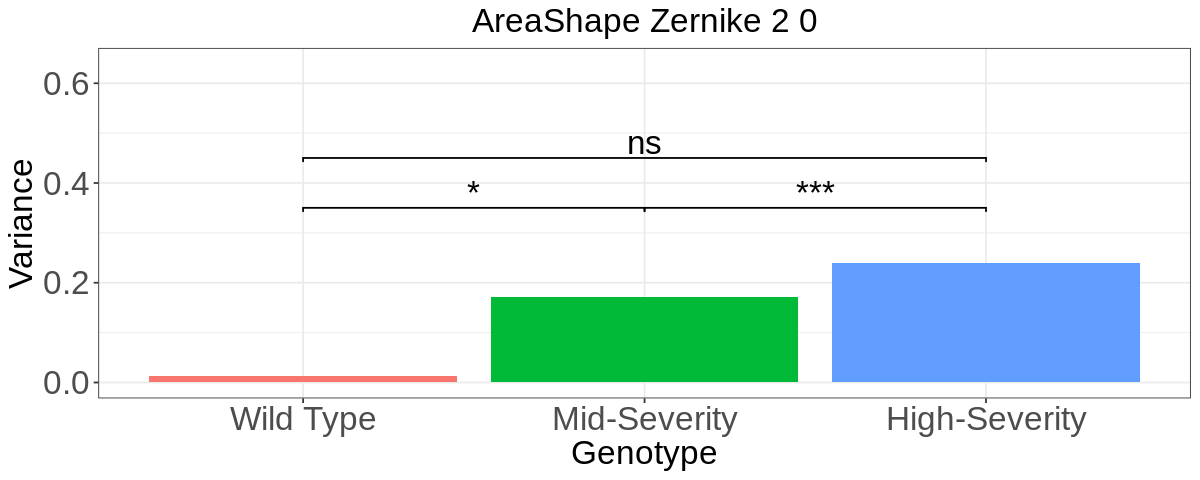

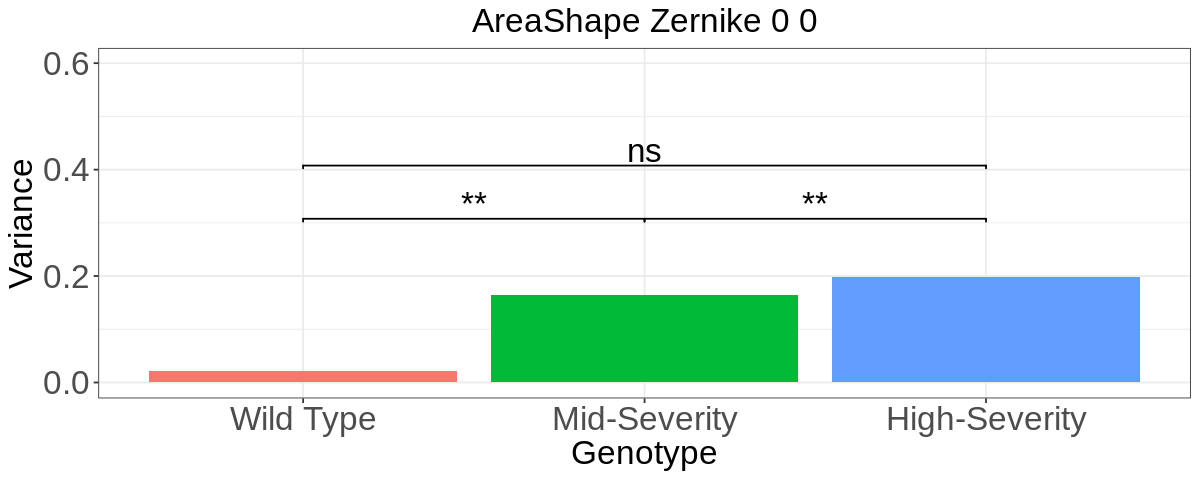

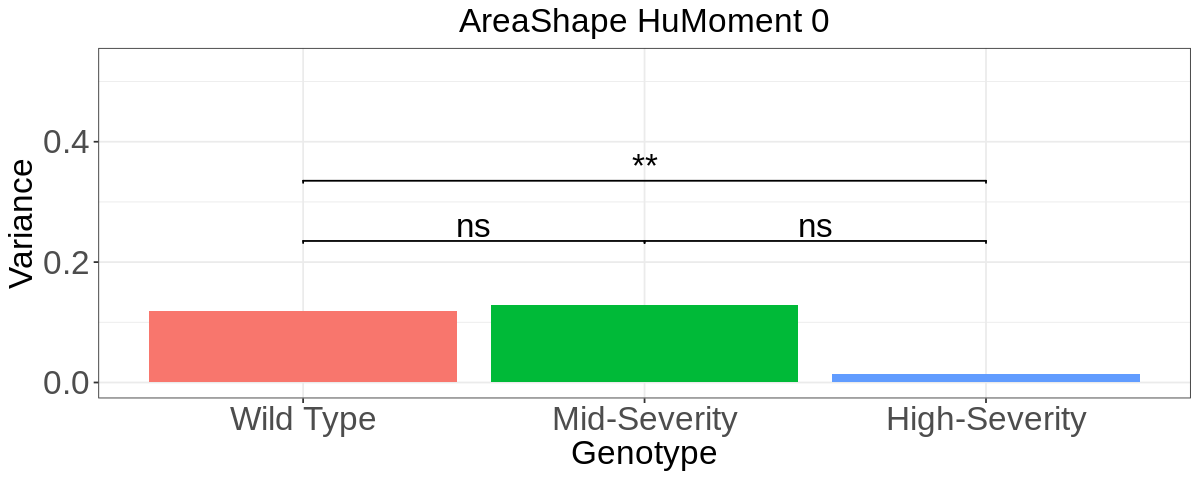

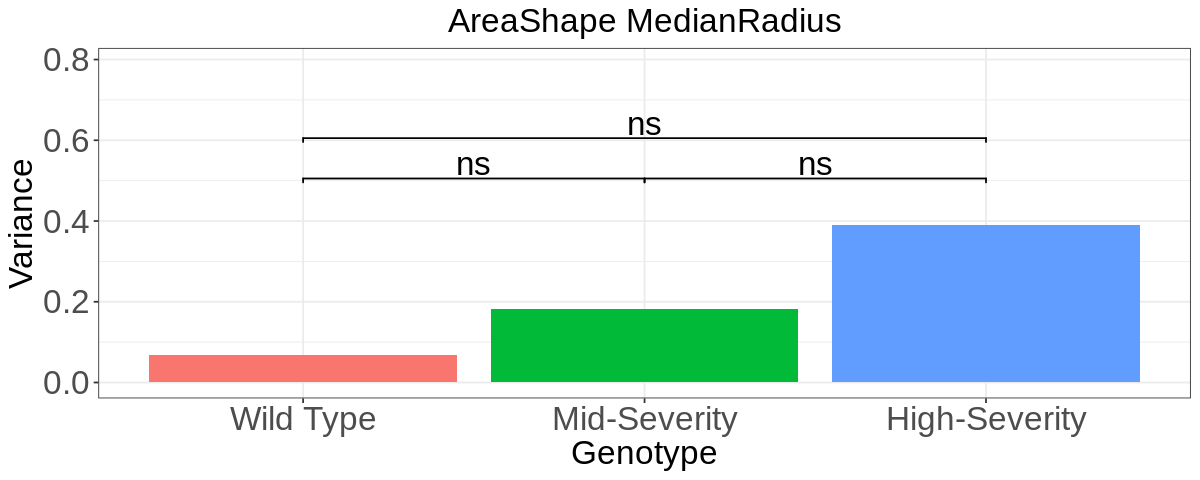

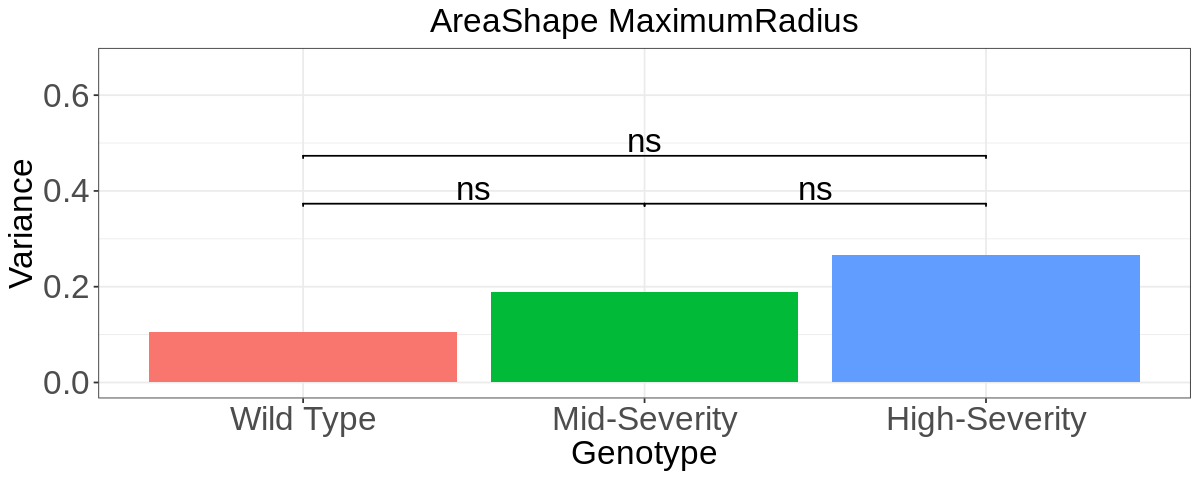

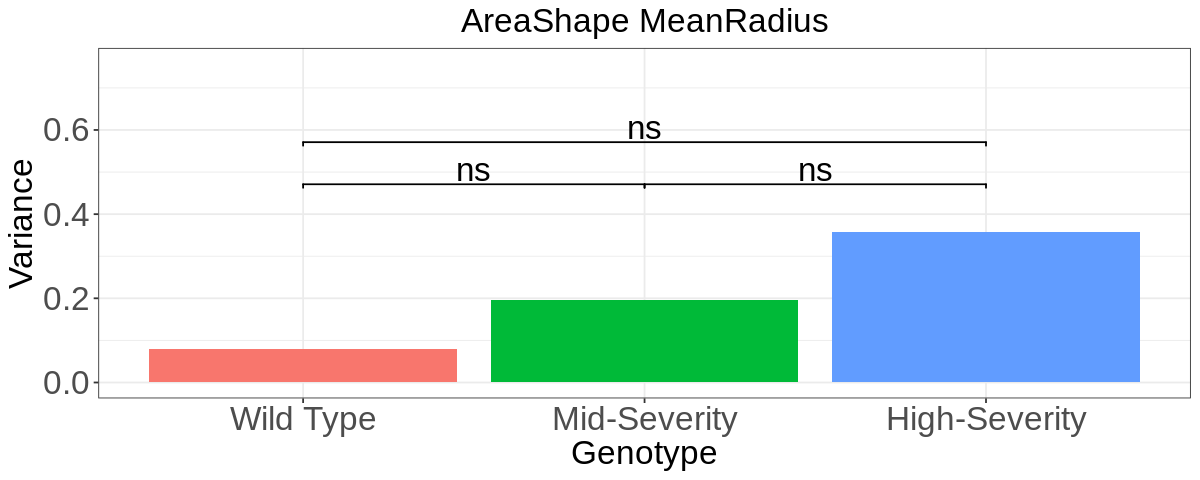

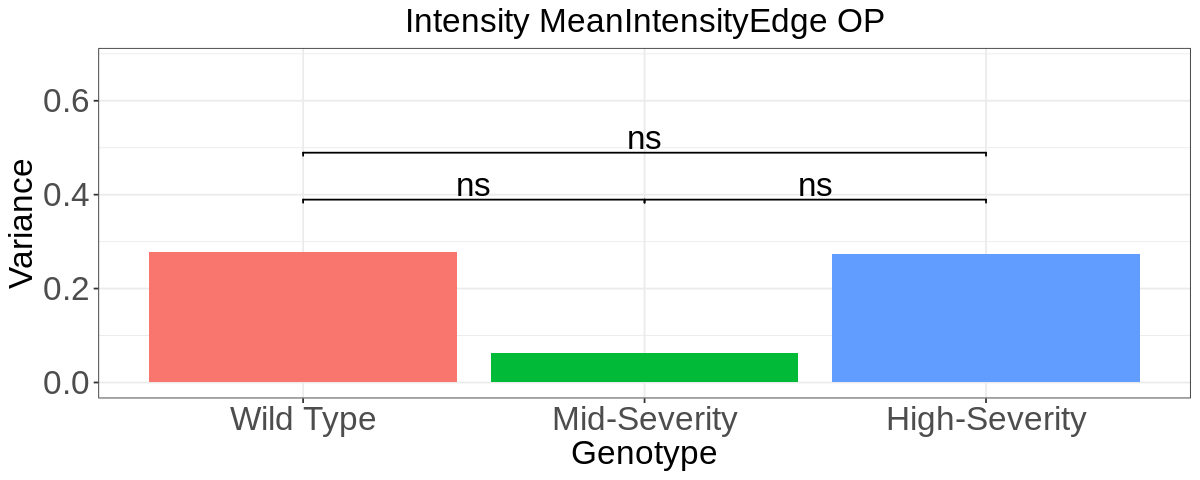

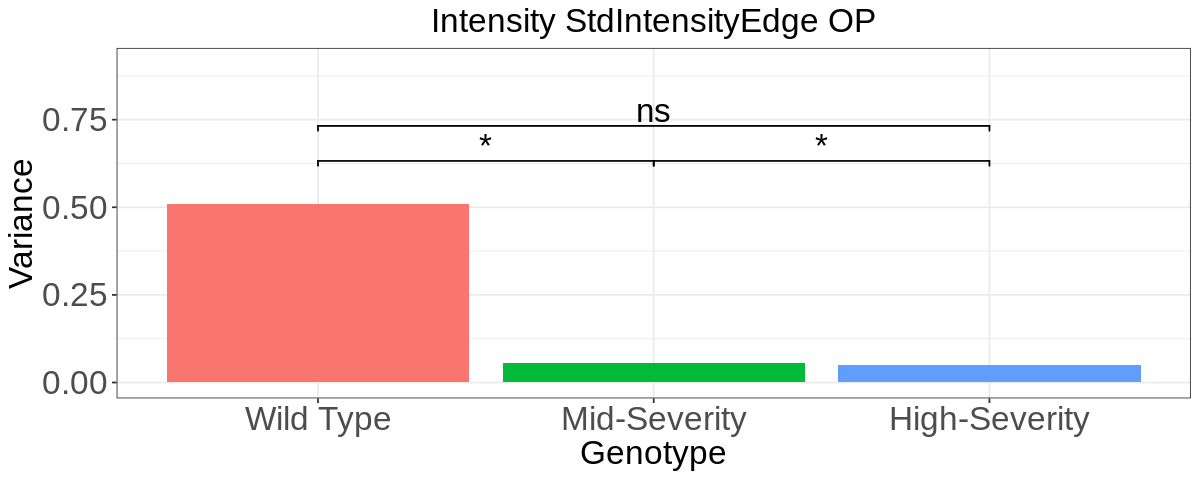

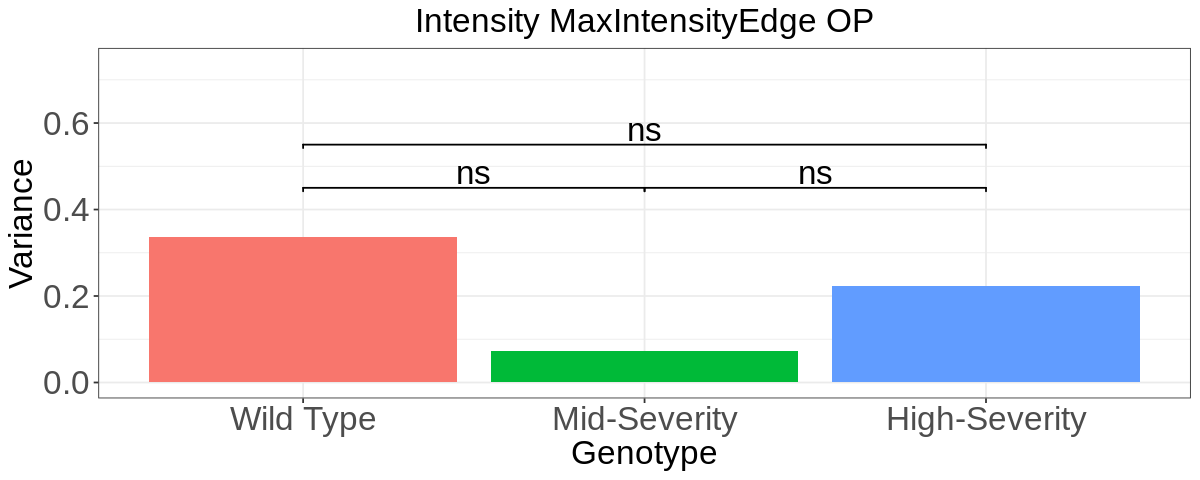

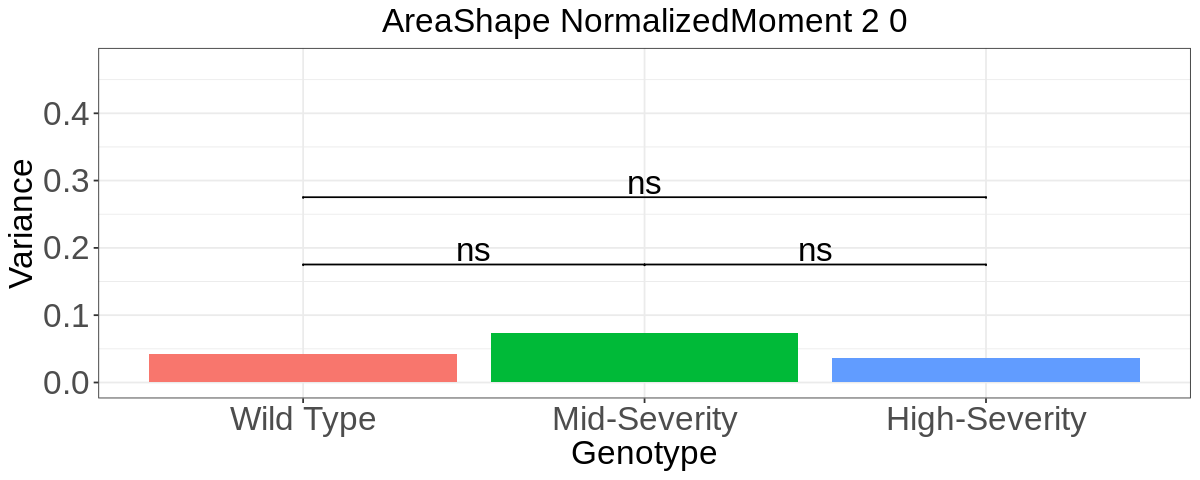

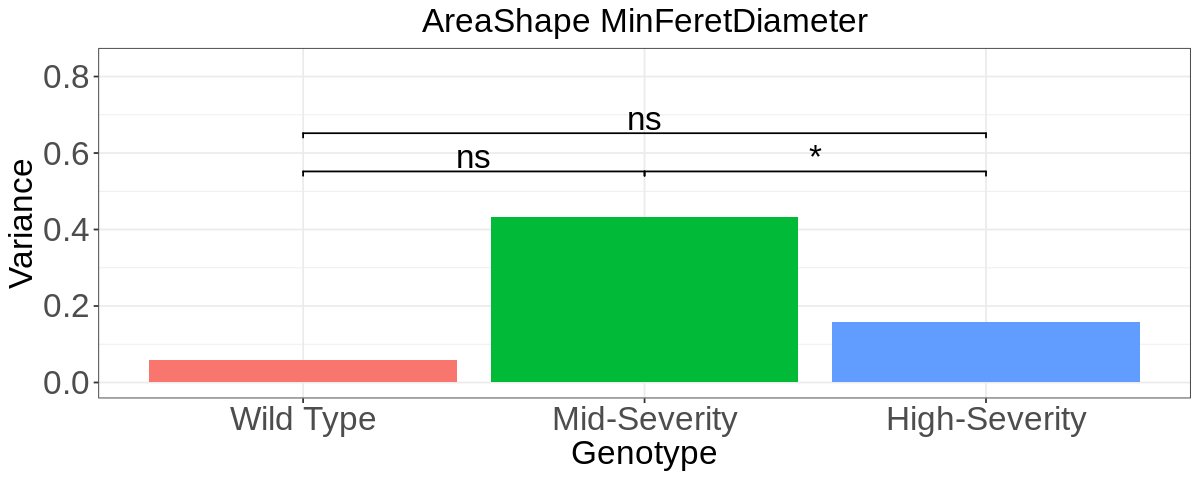

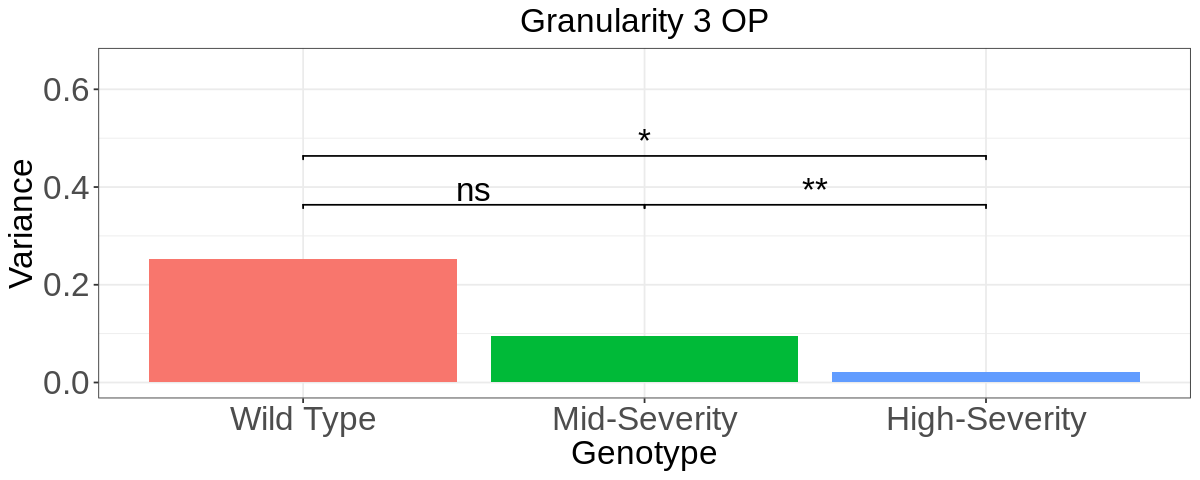

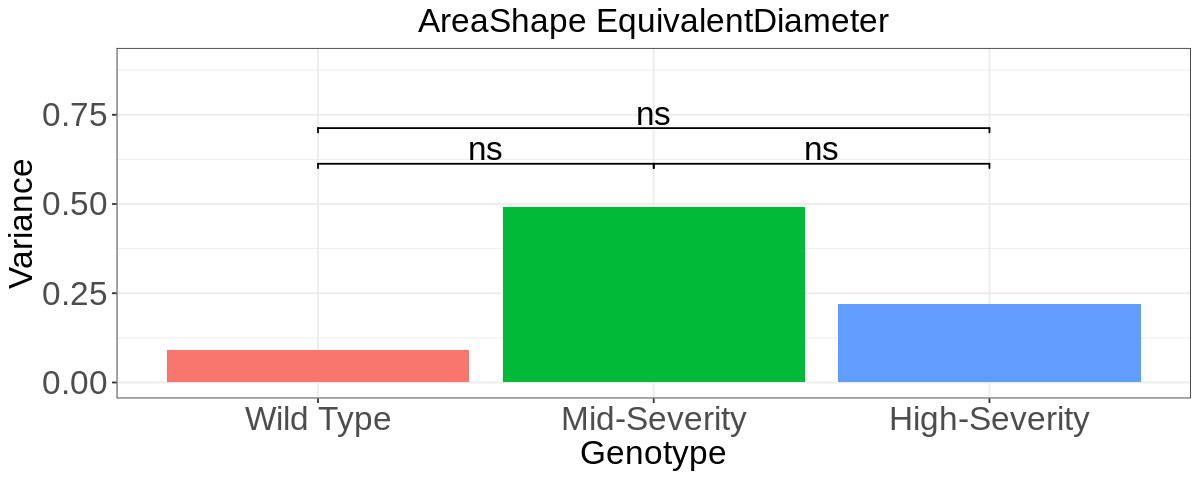

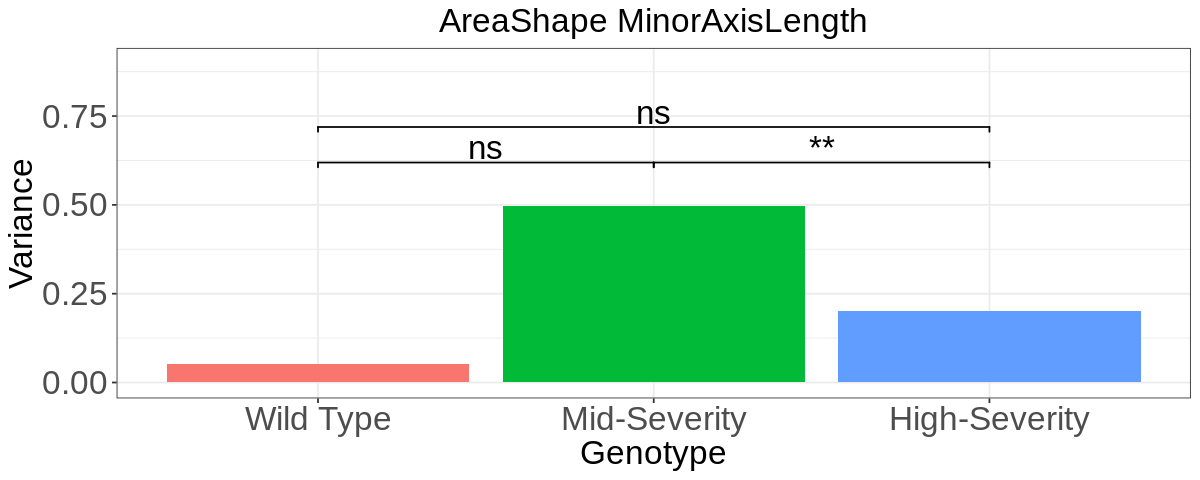

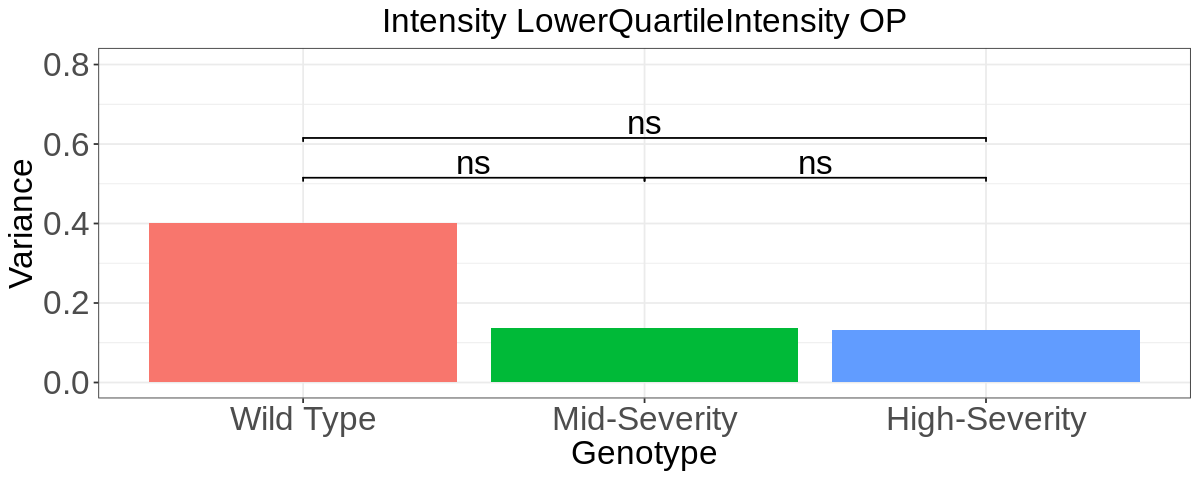

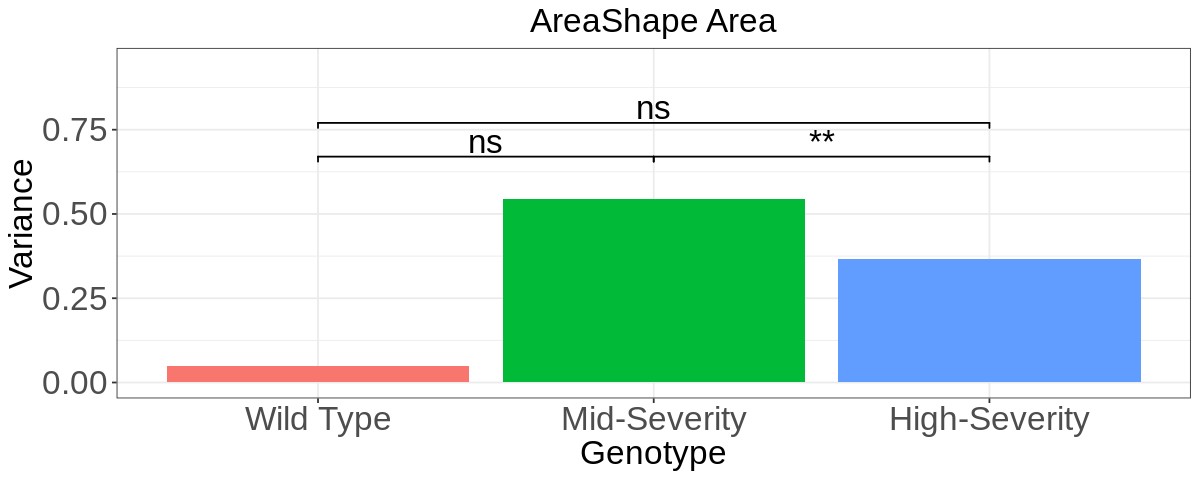

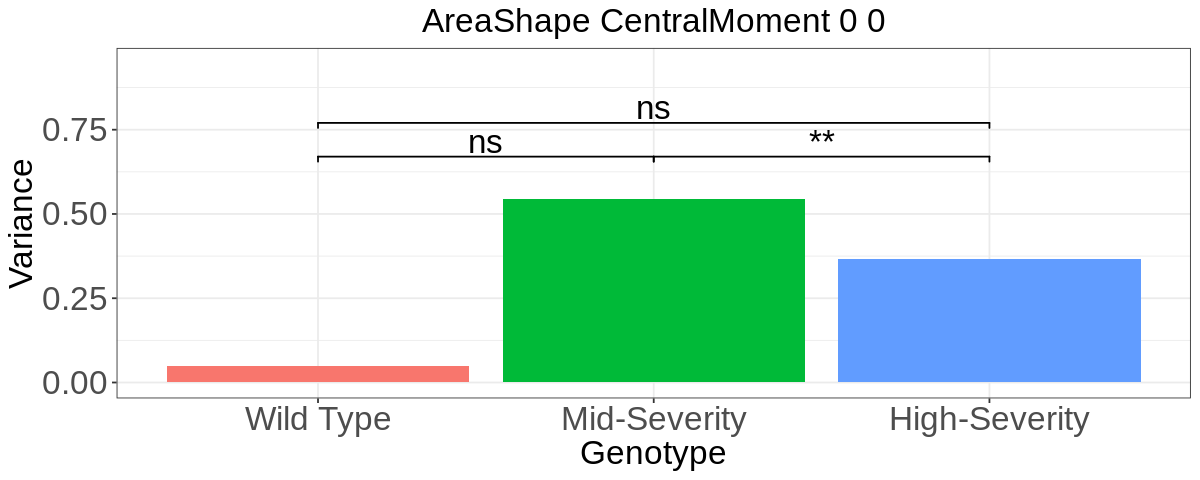

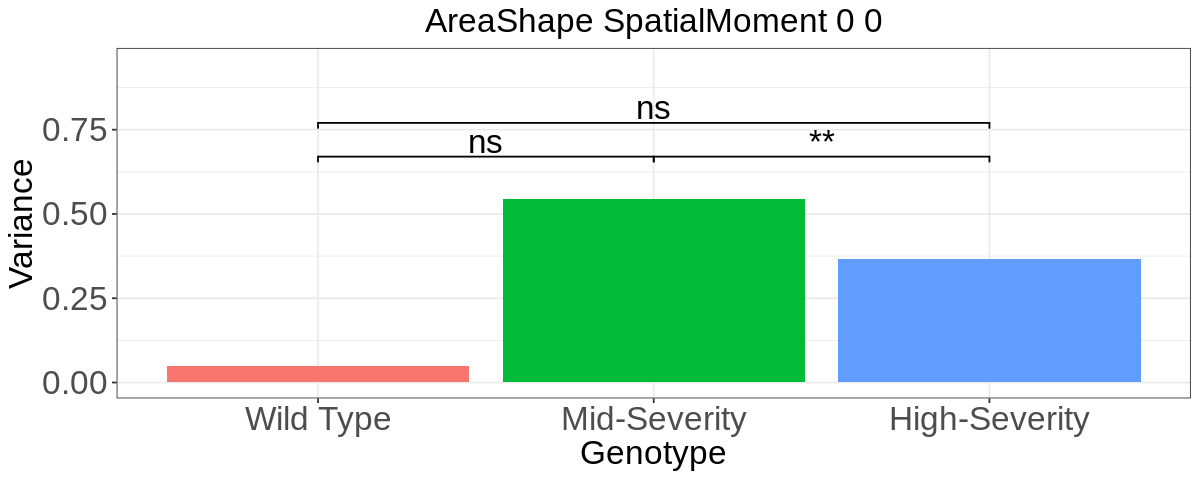

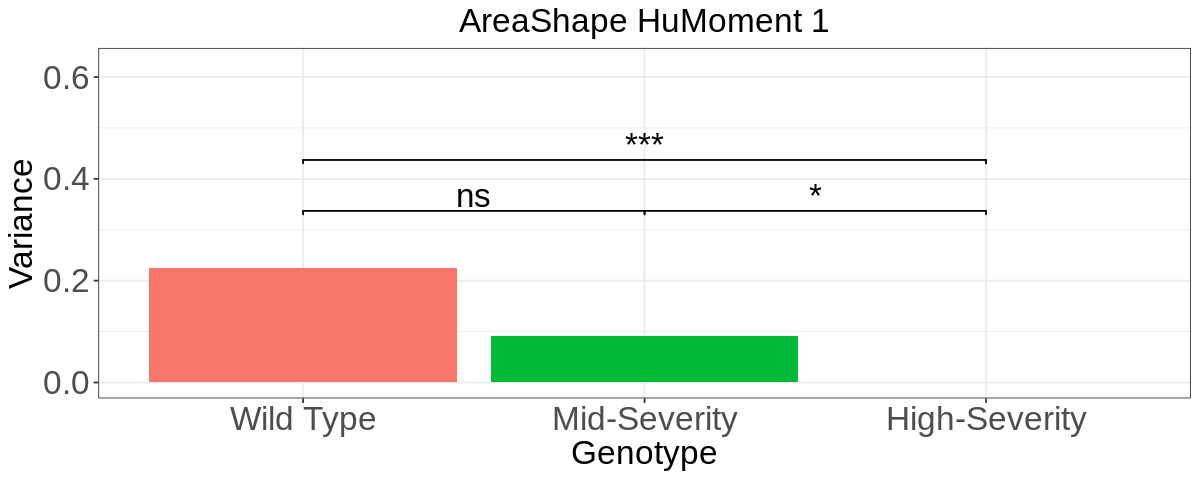

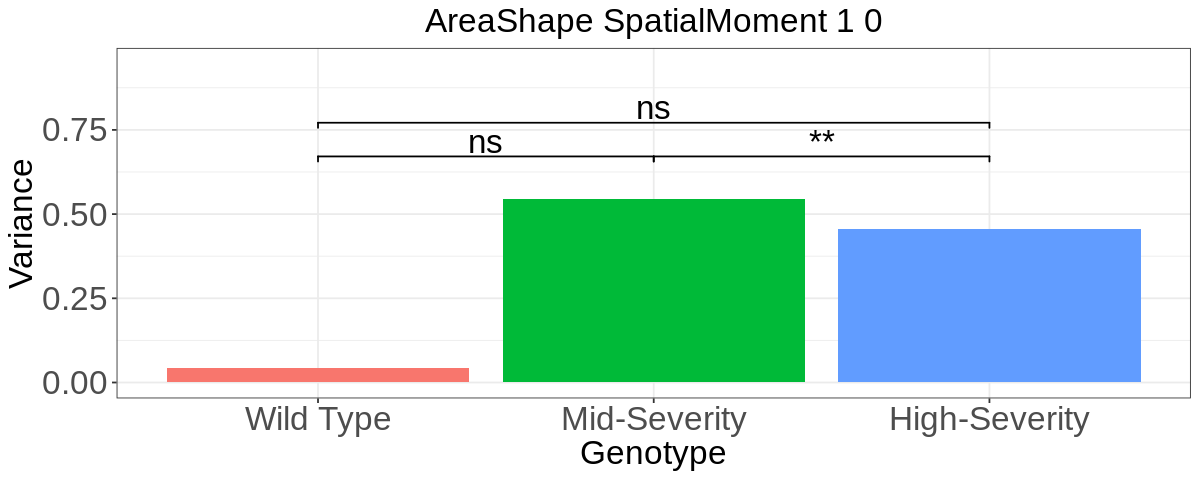

In [8]:
width <- 10
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
list_of_genotype_anova_plots_by_genotype[[1]]
list_of_genotype_anova_plots_by_genotype[[2]]
list_of_genotype_anova_plots_by_genotype[[3]]
list_of_genotype_anova_plots_by_genotype[[4]]
list_of_genotype_anova_plots_by_genotype[[5]]
list_of_genotype_anova_plots_by_genotype[[6]]
list_of_genotype_anova_plots_by_genotype[[7]]
list_of_genotype_anova_plots_by_genotype[[8]]
list_of_genotype_anova_plots_by_genotype[[9]]
list_of_genotype_anova_plots_by_genotype[[10]]
list_of_genotype_anova_plots_by_genotype[[11]]
list_of_genotype_anova_plots_by_genotype[[12]]
list_of_genotype_anova_plots_by_genotype[[13]]
list_of_genotype_anova_plots_by_genotype[[14]]
list_of_genotype_anova_plots_by_genotype[[15]]
list_of_genotype_anova_plots_by_genotype[[16]]
list_of_genotype_anova_plots_by_genotype[[17]]
list_of_genotype_anova_plots_by_genotype[[18]]
list_of_genotype_anova_plots_by_genotype[[19]]
list_of_genotype_anova_plots_by_genotype[[20]]
 